# Pansharpening Landsat using `xr_pansharpen` <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `DEA Sandbox` and `NCI` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background

Panchromatic sharpening ("pansharpening") is an image processing technique used to increase the spatial resolution of an image by combining a higher resolution "panchromatic" band with lower resolution multispectral bands. 
The resulting image has both the higher spatial resolution of the panchromatic band, and the spectral information of the multispectral bands.

Compared to multispectral satellite bands that cover multiple narrow portions of the electromagnetic spectrum, a panchromatic satellite band covers a wide range of spectra that overlaps with multiple multispectral bands.
This wider spectral range allows panchromatic bands to be collected at a higher spatial resolution due to a higher incoming signal-to-noise ratio.

Since Landsat 7, Landsat satellite sensors have included a 15 metre resolution panchromatic band.
Using pansharpening, we can use this band to increase the spatial resolution of Landsat multispectral bands from their usual 30 metre resolution to 15 metre resulution, resulting in higher resolution multispectral data.


## Description
In this example we will load Landsat 8 data, and demonstrate how to improve its spatial resolution from 30 to 15 metres using several common pansharpening transforms implemented using the `xr_pansharpen` function from `dea_tools.data_handling`:

1. First we will define our area of interest
2. Then we will set up the Brovey Transform
3. Load data at upsampled 15 x 15 m resolution and load data at native 30 x 30 m resolution for reference
4. Plot and compare the outputs

***

## Getting started

### Load packages
Import Python packages that are used for the analysis.

In [187]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import xr_pansharpen, mostcommon_crs, load_ard
from dea_tools.plotting import rgb
# from dea_tools.datahandling import mostcommon_crs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Connect to the datacube

Connect to the datacube so we can access DEA data:

In [188]:
dc = datacube.Datacube(app='Pan_sharpening')


### Analysis parameters

* `product`: The name of the product to pan-sharpen. This method works on DEA Landsat Collection 3 ARD Landsat 7 and Landsat 8 data - `ga_ls8c_ard_3` and `ga_ls7e_ard_3` are valid choices.
* `resolution`: Most Landsat bands collect data at a 30 x 30 m resolution, with the exception of the panchromatic band which is at 15 x 15 m.
Unless you are using this example with a different sensor, leave this at `(-15, 15)`.
* `align`: Alignment of the centre of the pixel. 
Leave this at `(7.5,7.5)` unless you know the data you are using requires a different pixel alignment
* `resampling`: When we use the DataCube to upsample the red, green and blue bands this is the resampling method to use. 
It is suggested to use `'bilinear'` however if you wish to experiment with different resampling methods you can use any of the [available methods here](https://github.com/mapbox/rasterio/blob/master/rasterio/enums.py#L28).
* `lon, lat, time`: Parameters to define our area of interest - feel free to adjust these.
* `measurements`: Landsat 7 and Landsat 8 have slightly different sensor configurations. 
For Landsat 8, Brovey Transform pan-sharpening should only be used with red, green and blue satellite bands. 
For Landsat 7, pan-sharpening can be used with red, green, blue and near infrared (`nbart_nir` or `nbar_nir`). 
For a visual explanation [see here]( https://landsat.gsfc.nasa.gov/wp-content/uploads/2013/01/ETM+vOLI-TIRS-web_Feb20131.jpg). 
An alternative selection of measurements could be `['nbart_red','nbart_green','nbart_blue','nbart_panchromatic']` but ensure that all your measurements are either terrain corrected (`nbart_`) or non-terrain corrected (`nbar_`).


In [189]:
# Parliament House, Canberra
query = {
    "x": (149.12, 149.144),
    "y": (-35.312, -35.29),
    "time": ('2015-01-02'),
}

### Determine native resolution (optional)
This section ensures your data is loaded in its 'native projection': the projection the data is stored in on file.
This will ensure maximum fidelity of your data by preventing data from being needlessly re-projected when loaded.

If this is not required, or you intend on re-projecting to a different CRS (e.g. `EPSG:3577`), then simply nominate your target CRS as `output_crs`.

In [190]:
# For the purposes of using our target dataset's native projection, 
# we determine its native crs before loading - while this yields 
# best results, it is optional
output_crs = mostcommon_crs(dc=dc, query=query, product="ga_ls8c_ard_3")
output_crs

'epsg:32655'

## Loading data
In this example we combine the Brovey Transform, Landsat 8's panchromatic band and multispectral data resampled using bilinear interpolation to pan-sharpen the red, green and blue Landsat bands from 30 x 30 m resolution to 15 x 15 m. 

In the cells below, we load red, green, blue and panchromatic band data at 15 m resolution, resampling the three visual bands using the `resampling` method specified above. 
For comparison, we also load the same three visual bands at their native 30 m resolution to serve as a reference dataset.

In [202]:
# Load red, green, blue and panchromatic band data for our area of
# interest at 15 m resolution
rgbp_15m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_panchromatic"],
    resolution=(-15, 15),
    align=(7.5, 7.5),
    output_crs=output_crs,
    resampling="bilinear",
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

Finding datasets
    ga_ls8c_ard_3
Loading 1 time steps


In [203]:
# For reference, load the same image at 30 m resolution
rgb_30m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    resolution=(-30, 30),
    align=(15, 15),
    output_crs=output_crs,
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

Finding datasets
    ga_ls8c_ard_3
Loading 1 time steps


### Visualise the panchromatic band
To visualise how the spatial resolution of Landsat's panchromatic band compares to the spatial resolution of the red, green and blue bands, we can plot both options. 
In the example below, we plot the 30 m Landsat 8 green band on the left, and the 15 m panchromatic band on the right. 
It should be clear how much additional spatial detail is visible in the panchromatic band.

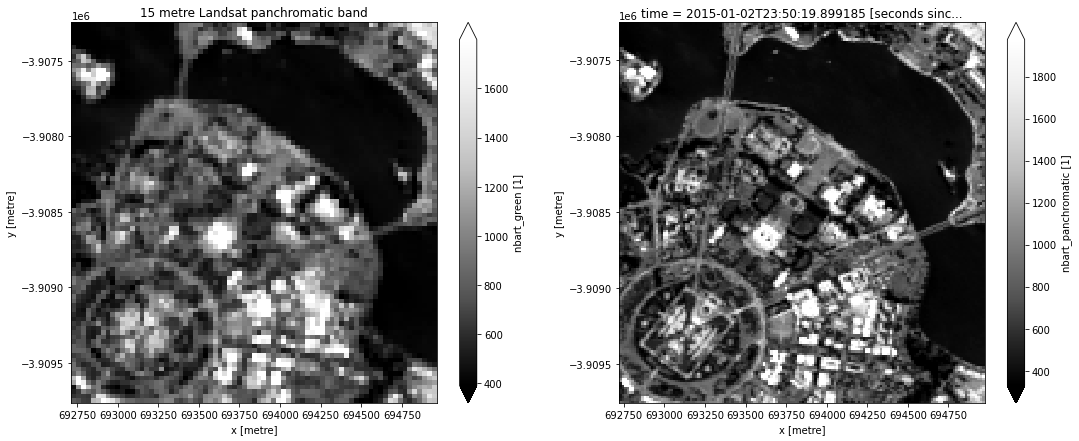

In [204]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
rgb_30m.nbart_green.plot(ax=axes[0], cmap="Greys_r", robust=True)
rgbp_15m.nbart_panchromatic.plot(ax=axes[1], cmap="Greys_r", robust=True)
axes[0].set_title("30 metre Landsat green band")
axes[0].set_title("15 metre Landsat panchromatic band");

## Apply Brovey pansharpening

In [206]:
# Perform Brovey pansharpening 
rgb_brovey_15m = xr_pansharpen(rgbp_15m, transform="brovey")


Applying Brovey pansharpening


### Plot and compare pansharpened data to original data

To evaluate our pan-sharpened image, we can compare it with our previously loaded reference data.
In the image below, we plot our original 30 m resolution reference data, the resampled but not pansharpened 15 m resolution input data, and finally our 15 m pansharpened image:

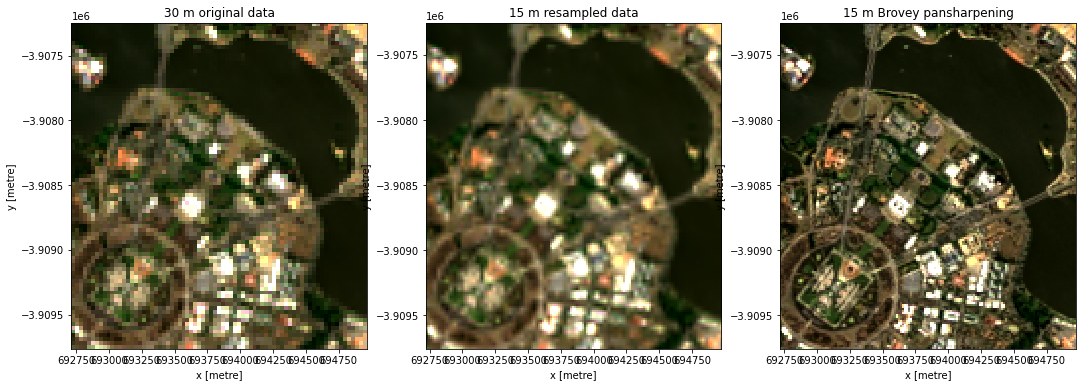

In [207]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
rgb(ds=rgb_30m, ax=axes[0])
rgb(ds=rgbp_15m, ax=axes[1])
rgb(ds=rgb_brovey_15m, ax=axes[2])
axes[0].set_title("30 m original data")
axes[1].set_title("15 m resampled data")
axes[2].set_title("15 m Brovey pansharpening");

Looking at the images above, the pansharpened image appears sharp and detailed, while still retaining the multispectral data (i.e. RGB colours) that were not originally included in the panchromatic band.

## Other pansharpening methods

In [208]:
rgb_simplemean_15m = xr_pansharpen(rgbp_15m, transform="simple mean")
rgb_esri_15m = xr_pansharpen(rgbp_15m, transform="esri")
rgb_hsv_15m = xr_pansharpen(rgbp_15m, transform="hsv")
rgb_pca_15m = xr_pansharpen(rgbp_15m, transform="pca")

Applying Simple mean pansharpening
Applying Esri pansharpening
Applying HSV pansharpening to each timestep
Applying PCA pansharpening to each timestep


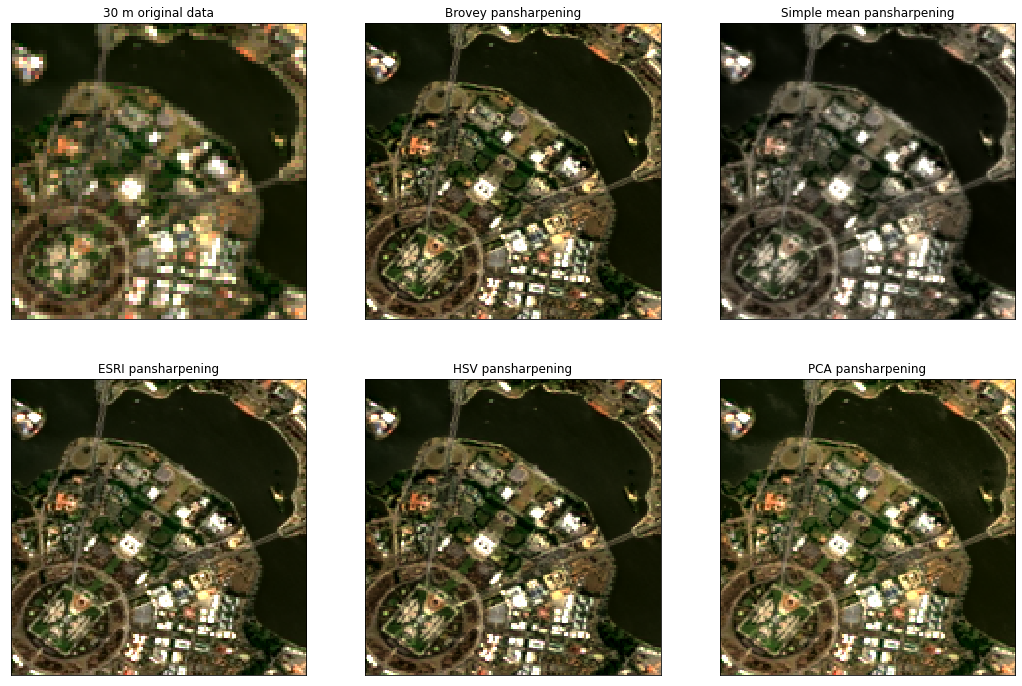

In [209]:
# Create empty 2 x 3 figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot each pansharpening method in RGB
rgb(ds=rgb_30m, ax=axes[0])
rgb(ds=rgb_brovey_15m, ax=axes[1])
rgb(ds=rgb_simplemean_15m, ax=axes[2])
rgb(ds=rgb_esri_15m, ax=axes[3])
rgb(ds=rgb_hsv_15m, ax=axes[4])
rgb(ds=rgb_pca_15m, ax=axes[5])

# Add titles to plots
axes[0].set_title("30 m original data")
axes[1].set_title("Brovey pansharpening")
axes[2].set_title("Simple mean pansharpening")
axes[3].set_title("ESRI pansharpening")
axes[4].set_title("HSV pansharpening")
axes[5].set_title("PCA pansharpening")

# Hide x and y axis labels
for ax in axes:
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

## Pansharpening multiple timesteps/images

In [218]:
query = {
    "x": (149.12, 149.144),
    "y": (-35.312, -35.29),
    "time": ('2015-01', '2015-04'),
    "cloud_cover": (0, 10)
}

# Load red, green, blue and panchromatic band data at 15 m resolution
rgbp_15m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_panchromatic"],
    resolution=(-15, 15),
    align=(7.5, 7.5),
    output_crs=output_crs,
    resampling="bilinear",
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

# For reference, load the same image at 30 m resolution
rgb_30m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    resolution=(-30, 30),
    align=(15, 15),
    output_crs=output_crs,
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

Finding datasets
    ga_ls8c_ard_3
Loading 4 time steps
Finding datasets
    ga_ls8c_ard_3
Loading 4 time steps


In [219]:
# Perform PCA pansharpening 
rgb_pca_15m = xr_pansharpen(rgbp_15m, transform="pca")

Applying PCA pansharpening to each timestep


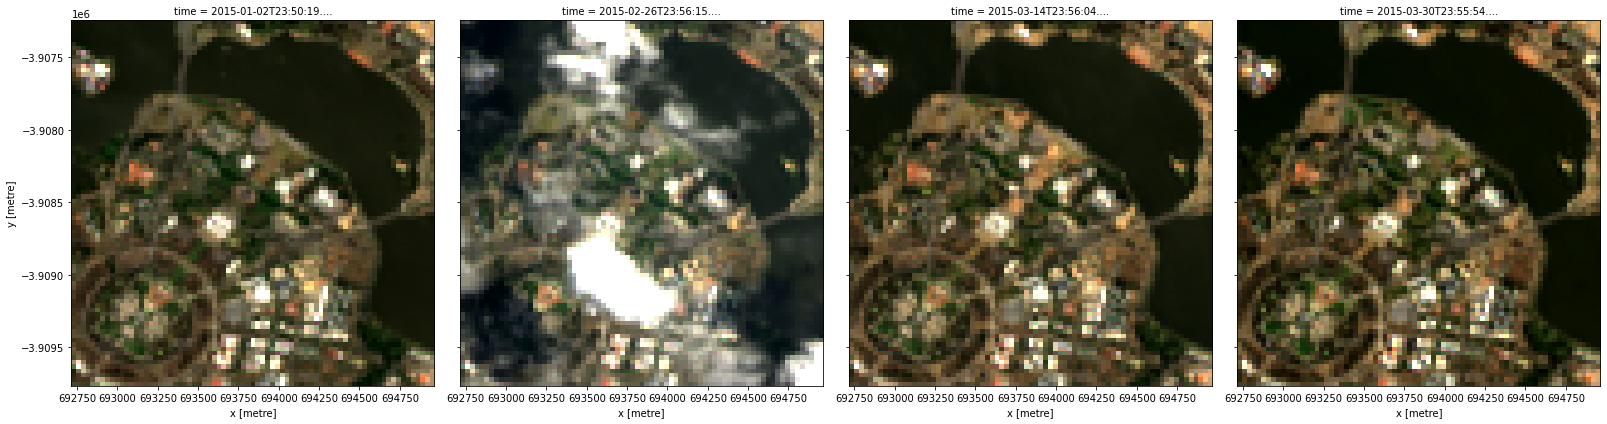

In [220]:
rgb(rgb_30m, col="time")

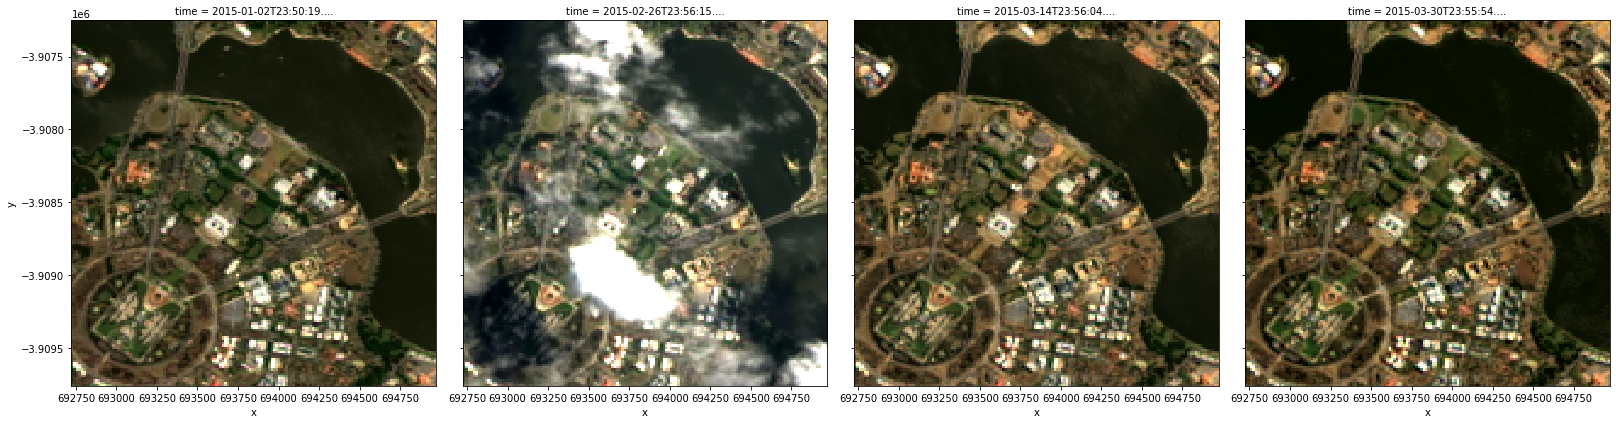

In [221]:
rgb(rgb_pca_15m, col="time")

## Pansharpening Landsat 7

In [264]:
# Load NIR, red, green and panchromatic band data at 15 m resolution
rgbp_15m = load_ard(dc=dc,
    products=["ga_ls7e_ard_3"],
    measurements=["nbart_nir", "nbart_red", "nbart_green", "nbart_panchromatic"],
    resolution=(-15, 15),
    align=(7.5, 7.5),
    output_crs=output_crs,
    resampling="bilinear",
    group_by="solar_day",
    mask_pixel_quality=False,
    mask_contiguity=True,
    **query
)

# For reference, load the same image at 30 m resolution
rgb_30m = load_ard(dc=dc,
    products=["ga_ls7e_ard_3"],
    measurements=["nbart_nir", "nbart_red", "nbart_green"],
    resolution=(-30, 30),
    align=(15, 15),
    output_crs=output_crs,
    group_by="solar_day",
    mask_pixel_quality=False,
    mask_contiguity=True,
    **query
)

Finding datasets
    ga_ls7e_ard_3
Applying contiguity mask
Loading 4 time steps
Finding datasets
    ga_ls7e_ard_3
Applying contiguity mask
Loading 4 time steps


In [265]:
# Perform PCA pansharpening 
rgb_pca_15m = xr_pansharpen(rgbp_15m, transform="pca")

Applying PCA pansharpening to each timestep


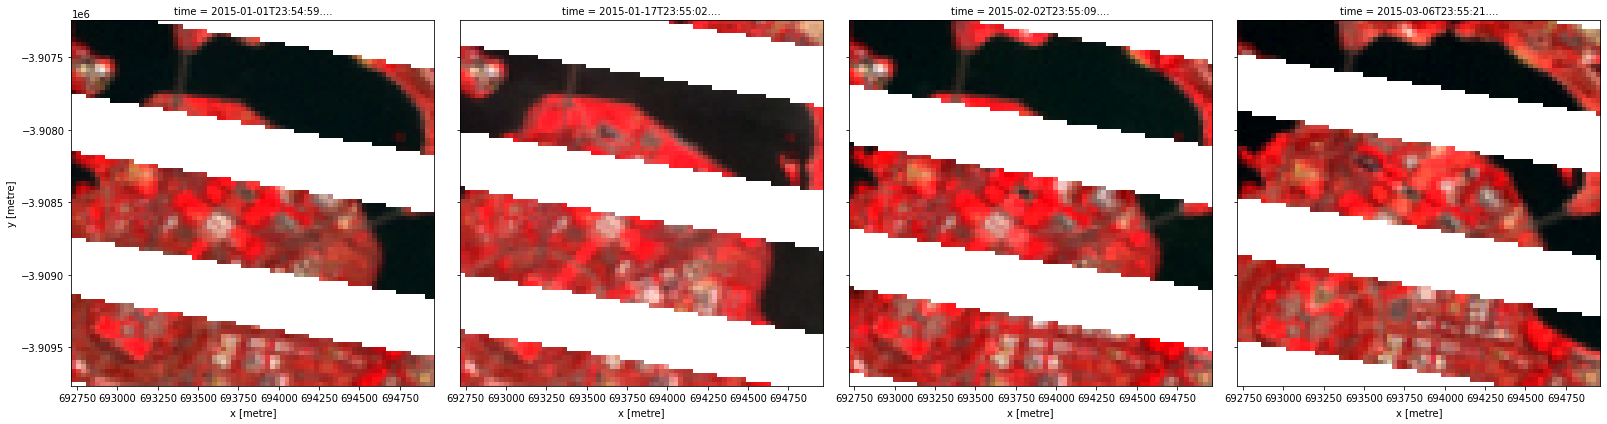

In [266]:
rgb(rgb_30m, bands=["nbart_nir", "nbart_red", "nbart_green"], col="time")

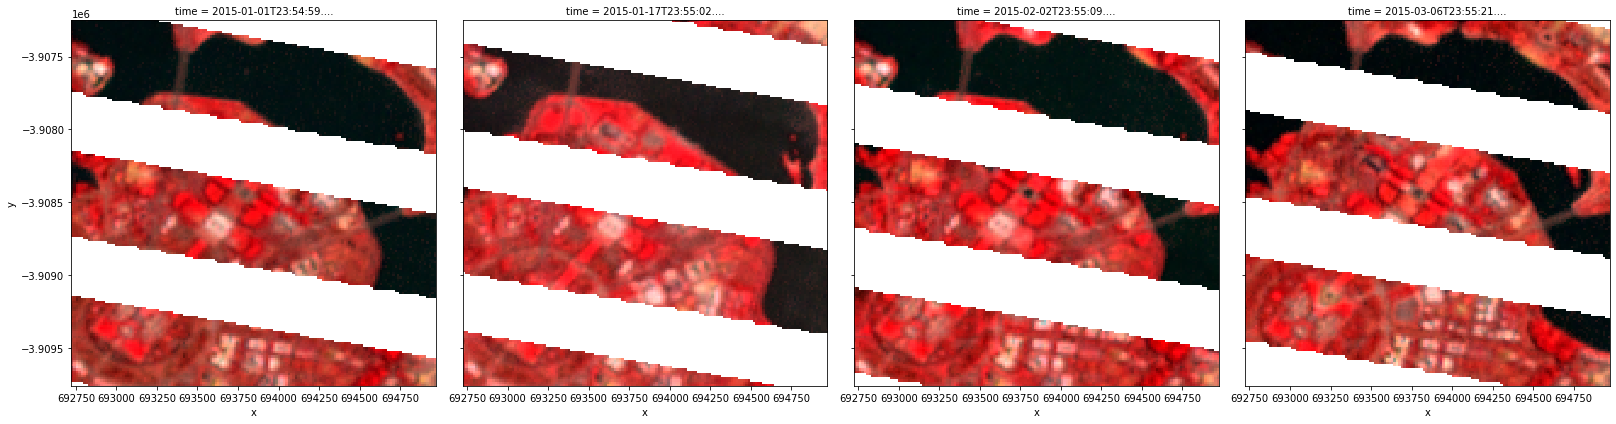

In [267]:
rgb(rgb_pca_15m, bands=["nbart_nir", "nbart_red", "nbart_green"], col="time")

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2023

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)